<a href="https://colab.research.google.com/github/gabrielbaltazarmw2/CAMUS-dataset/blob/main/UNET_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Resumo

1. **Importação das Bibliotecas**: Importação das bibliotecas necessárias, incluindo TensorFlow, NumPy, Pandas, Matplotlib, h5py e outras bibliotecas para construção do modelo UNet e visualizações.

2. **Carregamento do Dataset**: Carregamento das imagens de duas câmaras do coração do arquivo HDF5 usando h5py. Divisão dos dados em conjuntos de treinamento e teste.

7. **Separação de Conjuntos de Dados**: Separação dos conjuntos de treinamento e validação a partir dos conjuntos de treinamento originais.

3. **Definição das Métricas**: Definição das métricas personalizadas, como `multiclass_dice`, `dice_lv`, `dice_la` e `dice_myo`, para avaliar a qualidade da segmentação.

4. **Definição da Função de Perda**: Definição da função `generalized_dice_loss` que será usada como a função de perda durante o treinamento.

5. **Construção do Modelo UNet**: Implementação da arquitetura UNet usando camadas convolucionais e de pooling para segmentação de imagens.

6. **Compilação do Modelo**: Compilação do modelo UNet com a função de perda e métricas definidas. Sumário do modelo para exibir sua estrutura.

8. **Treinamento do Modelo**: Treinamento do modelo UNet usando os dados de treinamento e validação. Definição de callbacks como `EarlyStopping`, `ReduceLROnPlateau` e `ModelCheckpoint`.

9. **Salvamento do Histórico**: Salvamento do objeto `history` em um arquivo usando o módulo `pickle`. Esse histórico contém informações sobre métricas e perdas durante o treinamento.

10. **Carregamento do Modelo Treinado**: Carregamento do modelo treinado usando o método `load_model` do TensorFlow, com a inclusão das métricas personalizadas usando o dicionário `custom_objects`.

11. **Predição e Visualização**: Predição das máscaras segmentadas usando o modelo carregado. Exibição das imagens originais, máscaras de referência e máscaras preditas.

12. **Animação da Segmentação**: Opcionalmente, geração de uma animação que mostra as imagens originais sobrepostas com as máscaras preditas em cada etapa.

13. **Plotagem de Gráficos de Métricas**: Plotagem de gráficos de métricas, como acurácia, perda e Dice score, usando o histórico do treinamento.



#Importação das bibliotecas

In [1]:
# Standard
import os
import sys
import datetime
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
import tensorflow.keras.backend as K
from tensorflow import argmax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

# Utils
import h5py

#Carregando o dataset

In [2]:
from google.colab import drive

# Monta o Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Caminho do arquivo original no Google Drive
caminho_original = '/content/drive/MyDrive/Colab Notebooks/CAMUS DATASET/image_dataset.hdf5'

#Preparando os dados

In [4]:
f = h5py.File(caminho_original, "r")

utilizando o conjunto de imagens de duas câmaras do coração:

In [5]:
frames2ch = f["train 2ch frames"][:,:,:,:]
masks2ch = f["train 2ch masks"][:,:,:,:]

In [6]:
train_frames, test_frames, train_masks, test_masks = train_test_split(frames2ch, masks2ch)

In [7]:
train_frames.shape

(675, 384, 384, 1)

In [ ]:
test_frames.shape

(225, 384, 384, 1)

separando o conjunto de validação do conjunto de treinamento

In [8]:
valid_frames, valid_masks = train_frames[:100,:,:,:], train_masks[:100,:,:,:]
train_frames, train_masks = train_frames[100:,:,:,:], train_masks[100:,:,:,:]

In [ ]:
valid_frames.shape, train_frames.shape

((100, 384, 384, 1), (575, 384, 384, 1))

#Métricas

In [10]:
def multiclass_dice(y_true, y_pred, smooth=1e-7, num_classes=4):
    '''
    Multiclass Dice score. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,1:])
    y_pred_f = K.flatten(K.one_hot(argmax(y_pred, axis=3), num_classes=4)[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))


def dice_lv(y_true, y_pred, smooth=1e-7, num_classes=4):
    '''
    Multiclass Dice score. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,1:2])
    y_pred_f = K.flatten(K.one_hot(argmax(y_pred, axis=3), num_classes=4)[...,1:2])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_la(y_true, y_pred, smooth=1e-7, num_classes=4):
    '''
    Multiclass Dice score. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,3:4])
    y_pred_f = K.flatten(K.one_hot(argmax(y_pred, axis=3), num_classes=4)[...,3:4])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_myo(y_true, y_pred, smooth=1e-7, num_classes=4):
    '''
    Multiclass Dice score. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,2:3])
    y_pred_f = K.flatten(K.one_hot(argmax(y_pred, axis=3), num_classes=4)[...,2:3])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))


#Função de Perda

In [ ]:
def generalized_dice_loss(y_true, y_pred, smooth=1e-7, num_classes=4):

    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return 1.0-K.mean((2. * intersect / (denom + smooth)))

#Construção do modelo UNet

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

def conv_block(x, filters, kernel_size=3, padding="same", use_batch_norm=False):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding,
               kernel_initializer='he_normal')(x)
    x = Activation("relu")(x)
    if use_batch_norm:
        x = BatchNormalization()(x)
    return x

def UNet(input_size, depth, num_classes, base_filters, use_batch_norm):

    # Input layer
    inputs = Input(input_size)
    x = inputs

    # Encoding
    down_layers = []
    filters = base_filters
    for _ in range(depth):
        x = conv_block(x, filters, use_batch_norm=use_batch_norm)
        x = conv_block(x, filters, use_batch_norm=use_batch_norm)
        down_layers.append(x)
        x = MaxPooling2D(pool_size=2)(x)
        filters *= 2

    # Bottom
    x = conv_block(x, filters, use_batch_norm=use_batch_norm)
    x = conv_block(x, filters, use_batch_norm=use_batch_norm)

    # Decoding
    for layer in reversed(down_layers):
        filters //= 2
        x = UpSampling2D(size=(2, 2))(x)
        x = concatenate([x, layer])
        x = conv_block(x, filters, use_batch_norm=use_batch_norm)
        x = conv_block(x, filters, use_batch_norm=use_batch_norm)

    # Output layer
    x = Conv2D(filters=num_classes, kernel_size=1)(x)
    if use_batch_norm:
        x = BatchNormalization()(x)
    outputs = Activation("softmax")(x)

    model = Model(inputs, outputs)
    return model


In [ ]:
# Parâmetros
input_size = (384, 384, 1)  # Tamanho de entrada
depth = 4  # Profundidade da rede
num_classes = 4  # Número de classes de saída
filters = 32  # Número inicial de filtros
batch_norm = True  # Usar batch normalization

# Criar modelo UNet
model = UNet(input_size, depth, num_classes, filters, batch_norm)

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=1e-3), loss="sparse_categorical_crossentropy", metrics=[multiclass_dice, "accuracy"])

# Resumo do modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 384, 384, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 384, 384, 32  0           ['conv2d[0][0]']                 
                                )                                                             

#Treinamento

In [ ]:
def criar_diretorio(caminho):
  if not os.path.exists(caminho):
    os.makedirs(caminho)

In [ ]:
path_modelo = 'modelos'
criar_diretorio(path_modelo)

In [ ]:
earlystop = EarlyStopping(monitor='val_multiclass_dice', min_delta=0, patience=5,
                          verbose=1, mode="max", restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_multiclass_dice', factor=0.2, patience=2,
                              verbose=1, mode="max", min_lr=1e-5)

callbacks = [ModelCheckpoint(path_modelo + '/modelo_drive_{epoch:02d}.h5', verbose=1, save_best_only=True),
             earlystop, reduce_lr]

In [ ]:
history = model.fit(x=train_frames,
                    y=train_masks,
                    validation_data=[test_frames, test_masks],
                    batch_size=5,
                    epochs=50,
                    callbacks=callbacks)

Epoch 1/50
115/115 [==============================] - ETA: 0s - loss: 0.7923 - multiclass_dice: 0.6565 - accuracy: 0.8512
Epoch 1: val_loss improved from inf to 13.79275, saving model to modelos/modelo_drive_01.h5
115/115 [==============================] - 82s 428ms/step - loss: 0.7923 - multiclass_dice: 0.6565 - accuracy: 0.8512 - val_loss: 13.7927 - val_multiclass_dice: 0.2614 - val_accuracy: 0.1747 - lr: 0.0010
Epoch 2/50
115/115 [==============================] - ETA: 0s - loss: 0.5772 - multiclass_dice: 0.7947 - accuracy: 0.9204
Epoch 2: val_loss improved from 13.79275 to 3.88777, saving model to modelos/modelo_drive_02.h5
115/115 [==============================] - 46s 402ms/step - loss: 0.5772 - multiclass_dice: 0.7947 - accuracy: 0.9204 - val_loss: 3.8878 - val_multiclass_dice: 0.3588 - val_accuracy: 0.4549 - lr: 0.0010
Epoch 3/50
115/115 [==============================] - ETA: 0s - loss: 0.4784 - multiclass_dice: 0.8163 - accuracy: 0.9301
Epoch 3: val_loss improved from 3.88777

In [ ]:
# Salve o objeto 'history' em um arquivo usando o módulo pickle
history_path = 'history.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)

# Para plotar os gráficos posteriormente:

# Carregue o objeto 'history' do arquivo
with open(history_path, 'rb') as file:
    loaded_history = pickle.load(file)

# Salvar e carregar o modelo

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/CAMUS DATASET/model_unet2.h5')
print("Modelo salvo com sucesso!")

Modelo salvo com sucesso!


In [11]:
from tensorflow.keras.models import load_model

# Caminho para o modelo no Google Drive
caminho_modelo = '/content/drive/MyDrive/Colab Notebooks/CAMUS DATASET/model_unet2.h5'

# Load the model with the custom metric
custom_objects = {'multiclass_dice': multiclass_dice}
model_unet = load_model(caminho_modelo, custom_objects=custom_objects)

#Predição

1/1 [==============================] - 0s 22ms/step


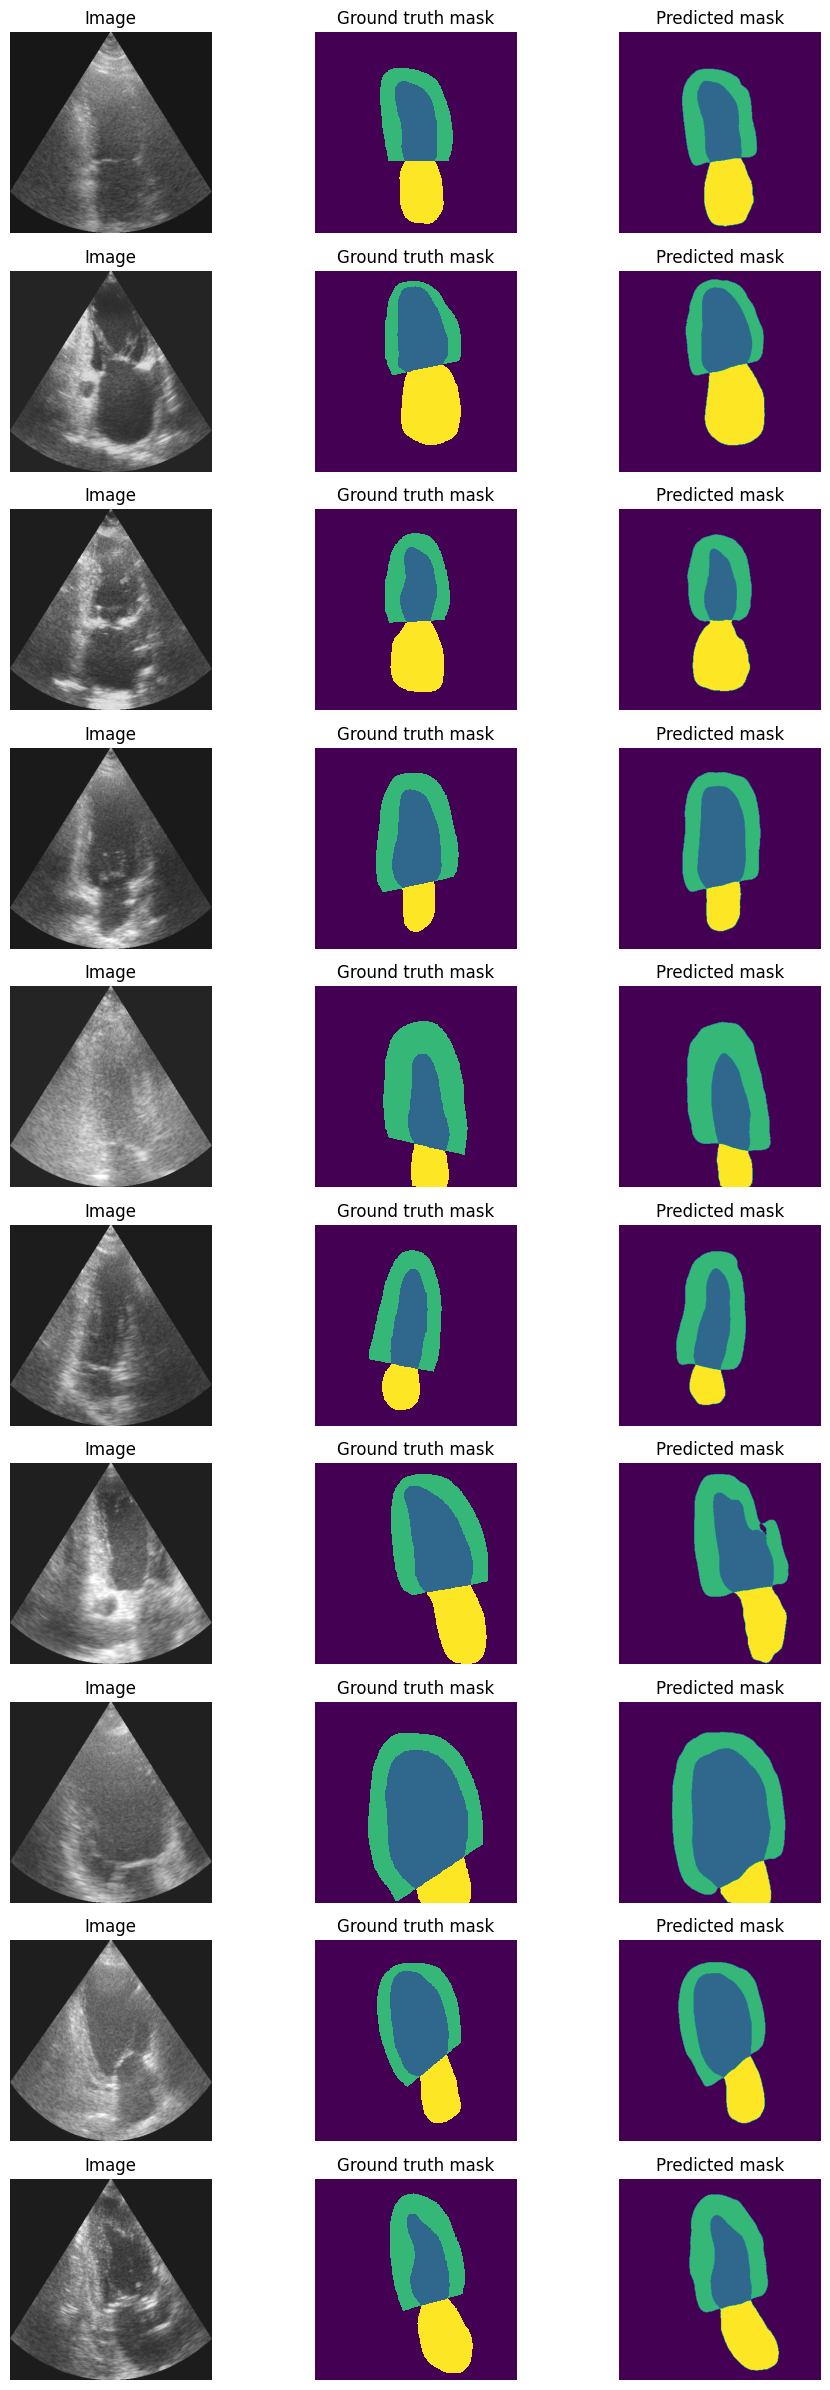

In [12]:
def display_image_grid(test_frames, test_masks, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = 10
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i in range(10):
        img = test_frames[i,:,:,0]
        mask = test_masks[i,:,:,0]

        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask)
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()


predicted_masks = []
for i in range(50):
    prediction = model_unet.predict(test_frames[i:i+1,:,:,:])
    prediction = prediction.reshape([384, 384, 4])
    y = tf.convert_to_tensor(prediction)
    predicted_masks.append(tf.math.argmax(prediction, axis = 2))

display_image_grid(test_frames, test_masks, predicted_masks=predicted_masks)

In [13]:
predicted_masks = np.array(predicted_masks)
predicted_masks.shape

(50, 384, 384)

In [14]:
pip install celluloid

In [15]:
from celluloid import Camera
from IPython.display import HTML

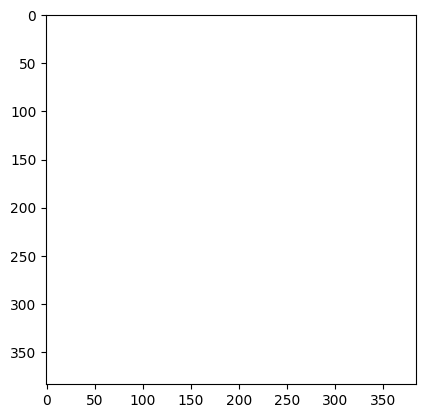

In [21]:
fig = plt.figure()
camera = Camera(fig)  # Create the camera object from celluloid

for i in range(len(predicted_masks)):
    plt.imshow(test_frames[i,:,:], cmap="gray")
    plt.imshow(predicted_masks[i,:,:], alpha=0.4)
    camera.snap()  # Store the current slice
animation = camera.animate()  # Create the animation




In [22]:
HTML(animation.to_html5_video())  # convert the animation to a video


In [18]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
plot_graphs(history, "multiclass_dice")

NameError: ignored